<a href="https://colab.research.google.com/github/ideablast/NLPer_chatbot/blob/kdg/%EC%B1%97%EB%B4%87_classification_bad_ISSUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

## Import

In [8]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

from konlpy.tag import Okt

## Hyperparameter

In [3]:
# 태그 단어
PAD = "<PADDING>"   # 패딩
STA = "<START>"     # 시작
END = "<END>"       # 끝
OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)

# 태그 인덱스
PAD_INDEX = 0
STA_INDEX = 1
END_INDEX = 2
OOV_INDEX = 3

# 데이터 타입
ENCODER_INPUT  = 0
DECODER_INPUT  = 1
DECODER_TARGET = 2

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256 ##word embedding dim
NUM_HEADS = 8 ## D_Model % NUM_HEADS == 0이 되야하므로...
UNITS = 512
DROPOUT = 0.1
EPOCHS = 50
# for data pipelining
BATCH_SIZE = 64
BUFFER_SIZE = 1000

VOCAB_SIZE = 0 # 후에 len(words) 로 바뀜.

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30

# 정규 표현식 필터
RE_FILTER = re.compile("[\"':;~()]")

## Data Load & Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
wear_data = pd.read_csv("/content/drive/My Drive/wear.csv")
print(wear_data.shape)
customer = wear_data[wear_data.SPEAKER == "고객"].SENTENCE
store = wear_data[wear_data.SPEAKER == "점원"].SENTENCE
print(customer.shape, store.shape) # 질문의 개수와 답의 개수가 일치하지 않는다.

(15826, 20)
(8381,) (7445,)


In [42]:
# 점원,고객 중 두번 말하면 그것을 한 문장으로 전처리
prev = "고객"
store_arr = []
customer_arr = []
store_stc = ""
customer_stc = ""

for i in range(wear_data.shape[0]):
    if (prev == wear_data.iloc[i].SPEAKER):
        if prev == "점원":
             store_stc += (" "+wear_data.iloc[i].SENTENCE)
        else : 
             customer_stc += (" "+wear_data.iloc[i].SENTENCE)
            
    elif prev == "점원":
        store_arr.append(store_stc)
        customer_stc = wear_data.iloc[i].SENTENCE
        prev = "고객"
    else :
        customer_arr.append(customer_stc)
        store_stc = wear_data.iloc[i].SENTENCE
        prev = "점원"
print(len(store_arr))
print(len(customer_arr))
print(store_arr[-1])
print(customer_arr[-1]) 

7301
7301
요즘 파스텔 톤이 유행이에요
요즘 유행하는 색깔이 뭐예요?


In [52]:
faqs = [] # [[index, 고객의 문장, 점원의 문장, 카테고리, 의도)]...]

for i in range(len(store_arr)):
    faqs_tmp =[]
    faqs_tmp.append(str(i+1))
    faqs_tmp.append(customer_arr[i].lstrip())
    faqs_tmp.append(store_arr[i])
    faqs_tmp.append(max(wear_data[wear_data.SENTENCE == customer_arr[i].lstrip()].CATEGORY.tolist())) 
    #카테고리중 가장 많은 값을 채우려다 customer_arr[i]와 일치하는 문장이 없는 경우가 있어서 막힘.
    faqs_tmp.append(max(wear_data[wear_data.SENTENCE == customer_arr[i].lstrip()].MAIN.tolist()))

    faqs.append(faqs_tmp)

ValueError: ignored

In [72]:
wear_data.SENTENCE.values.tolist()

['신발은 여기 있는 게 다예요?',
 '네 성인이나 아동 다 있어요',
 '발 사이즈 몇 신으세요?',
 '230이요',
 '편하게 신을 수 있는 거 찾으세요?',
 '네 봄이니까 편하게 신을 수 있는 거',
 '이런 건 어떠세요? 이런 거도 신발 무척 편하거든요',
 '굽 좀 높은 거 없나요?',
 '봄 상품은 아직 어른 제품이 많이 안나왔습니다',
 '언제 들어와요?',
 '이번주 지나면 들어올 거예요',
 '이거는 가죽이에요?',
 '가죽 아니고 쎄무예요',
 '가죽은 얼마예요?',
 '2만 9천 원입니다',
 '털 달린 거 저거는 사이즈 있어요?',
 '230이 없어요 ',
 '이거 한 번 신어보세요',
 '좀 크네',
 '또 안 들어와요?',
 '네 이건 다 끝났어요',
 '가방 매는 거 보고 있어요',
 '여기 있어요',
 '가격이 얼마예요?',
 '이 종류는 2만 원이고 이 종류는 3만 8천 원이에요',
 '가죽으로 된 거는 없어요?',
 '가죽은 없고 레자만 있어요',
 '레자는 얼마예요?',
 '5만 5천 원요',
 '이거는 천이죠?',
 '네 맞아요',
 '이건 얼마예요?',
 '그것도 5만 5천 원요',
 '이거 끈은 따로 없어요?',
 '안에 있어요',
 '내일은 문 열어요?',
 '휴무입니다',
 '며칠까지 휴무예요?',
 '설까지 쉬고 다음날 열 거 같아요',
 '여기 마스크는 얼마예요?',
 '5천 원요',
 '이거 나무예요? 다 돌인가요?',
 '나무도 있고 도자기도 있어요',
 '이런 건 세트로 팔아요?',
 '네 세트로만 팔아요',
 '이건 뭐예요?',
 '마블이라고 종이를 말아가지고 하는 거예요',
 '제일 큰 거는 얼마인데요?',
 '세트에 7만 원이요',
 '스카프 좀 보려구요',
 '네 천천히 보세요',
 '실크스카프도 봄에 하나요?',
 '실크 봄 가을에 하죠',
 '이거는 뭐예요?',
 '토시예요',
 '여기 가격은 그대로 파시는 거예요?',
 '네 핸드메이드로 해가지고 그 가격으로 팔아요',
 '착용해볼 수 있어요

In [67]:
customer_arr[8]

'좀 크네 또 안 들어와요?'

In [66]:
wear_data[wear_data.SENTENCE.values. == customer_arr[8].lstrip()].CATEGORY

,SPEAKER,SENTENCE,DATAID,DOMAINID,DOMAIN,CATEGORY,SPEAKERID,SENTENCEID,MAIN,SUB,QA,QACNCT,MQ,SQ,UA,SA,개체명,용어사전,지식베이스,Unnamed: 19
3,고객,230이요,박은영_액세서리_5,B,의복의류점,신발,1,4,종류별신발제품문의요청,사이즈,A,NaN,NaN,NaN,230이요,NaN,230,NaN,230/사이즈,NaN
5,고객,네 봄이니까 편하게 신을 수 있는 거,박은영_액세서리_5,B,의복의류점,신발,1,6,착화감,제품문의,A,NaN,NaN,NaN,네 봄이니까 편하게 신을 수 있는 거,NaN,봄,NaN,봄/계절,NaN
7,고객,굽 좀 높은 거 없나요?,박은영_액세서리_5,B,의복의류점,신발,1,8,굽높이문의,NaN,Q,NaN,굽 좀 높은 거 없나요?,NaN,NaN,NaN,굽,NaN,굽/부분,NaN
9,고객,언제 들어와요?,박은영_액세서리_5,B,의복의류점,신발,1,10,재입고문의,NaN,Q,NaN,언제 들어와요?,NaN,NaN,NaN,언제,NaN,NaN,NaN
11,고객,이거는 가죽이에요?,박은영_액세서리_5,B,의복의류점,신발,1,12,소재문의,NaN,Q,NaN,이거는 가죽이에요?,NaN,NaN,NaN,"이거, 가죽",NaN,가죽/소재,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15386,고객,포인트 적립되죠?,생성,B,의복의류점,신발,1,487,포인트적립문의,NaN,Q,NaN,포인트 적립되죠?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15464,고객,어디에 있나요?,생성,B,의복의류점,신발,1,565,제품위치문의,NaN,Q,NaN,어디에 있나요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15605,고객,운동화 있나요?,생성,B,의복의류점,신발,1,706,종류별신발제품문의/요청,NaN,Q,NaN,운동화 있나요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15672,고객,이거 국산이에요?,생성,B,의복의류점,액세서리,1,773,제품제작한나라문의,NaN,Q,NaN,이거 국산이에요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
for i in range(len(store_arr)):
    print(i)
    max(wear_data[wear_data.SENTENCE == customer_arr[i].lstrip()].CATEGORY.tolist())

0
1
2
3
4
5
6
7
8


ValueError: ignored

In [48]:
faqs[10:15]

[['11',
  '가격이 얼마예요?',
  '이 종류는 2만 원이고 이 종류는 3만 8천 원이에요',
  '가방',
  '의류',
  '의류',
  '의류',
  '신발',
  '신발',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의'],
 ['12', '가죽으로 된 거는 없어요?', '가죽은 없고 레자만 있어요', '가방', '소재를제시한제품문의'],
 ['13', '레자는 얼마예요?', '5만 5천 원요', '가방', '제품가격문의'],
 ['14', '이거는 천이죠?', '네 맞아요', '가방', '가방소재문의'],
 ['15',
  '이건 얼마예요?',
  '그것도 5만 5천 원요',
  '가방',
  '액세서리',
  '액세서리',
  '액세서리',
  '액세서리',
  '의류',
  '신발',
  '신발',
  '가방',
  '의류',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의',
  '제품가격문의']]

In [39]:
wear_data[wear_data.SENTENCE == customer_arr[0].lstrip()].CATEGORY.tolist()

['신발']

In [31]:
len(faqs)

7301

In [26]:
arr

['신발은 여기 있는 게 다예요?']

In [11]:
prev = "고객"
store_arr = []
customer_arr = []
store_stc = ""
customer_stc = ""

for i in range(wear_data.shape[0]):
    if (prev == wear_data.iloc[i].SPEAKER):
        if prev == "점원":
             store_stc += (" "+wear_data.iloc[i].SENTENCE)
        else : 
             customer_stc += (" "+wear_data.iloc[i].SENTENCE)
            
    elif prev == "점원":
        store_arr.append(store_stc)
        customer_stc = wear_data.iloc[i].SENTENCE
        prev = "고객"
    else :
        customer_arr.append(customer_stc)
        store_stc = wear_data.iloc[i].SENTENCE
        prev = "점원"
faqs = []

for i in range(len(store_arr)):
    faqs_tmp =[]
    faqs_tmp.append(str(i+1))
    faqs_tmp.append(customer_arr[i])
    faqs_tmp.append(store_arr[i])

    faqs.append(faqs_tmp)
print(len(store_arr))
print(len(customer_arr))
print(store_arr[-1])
print(customer_arr[-1]) # 자료 상에서 이후에는 계속 고객의 물음만 계속된다. 코드 레벨에서 이 부분은 빼게 구현했다. (stc는 만들어지지만 arr에 append 안하게 된다.)

7301
7301
요즘 파스텔 톤이 유행이에요
요즘 유행하는 색깔이 뭐예요?


In [7]:
question = []
answer = []

for Q in customer_arr:
    question.append(Q.replace("[^\w]", " "))

for A in store_arr:
    answer.append(A.replace("[^\w]", " "))

len(question), len(answer)

(7301, 7301)

In [9]:
# 형태소분석 함수
def pos_tag(sentences):
    
    # KoNLPy 형태소분석기 설정
    tagger = Okt()
    
    # 문장 품사 변수 초기화
    sentences_pos = []
    
    # 모든 문장 반복
    for sentence in sentences:
        # [\"':;~()] 특수기호 제거
        sentence = re.sub(RE_FILTER, "", sentence)
        
        # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
        sentence = " ".join(tagger.morphs(sentence))
        sentences_pos.append(sentence)
        
    return sentences_pos

In [10]:
# 형태소분석 수행
question = pos_tag(question)
answer = pos_tag(answer)

# 형태소분석으로 변환된 챗봇 데이터 출력
for i in range(5):
    print('Q : ' + question[i])
    print('A : ' + answer[i])
    print()


Q : 신발 은 여기 있는 게 다예 요 ?
A : 네 성인 이나 아동 다 있어요 발 사이즈 몇 신으세요 ?

Q : 230 이요
A : 편하게 신 을 수 있는 거 찾으세요 ?

Q : 네 봄 이니까 편하게 신 을 수 있는 거
A : 이런 건 어떠세요 ? 이런 거도 신발 무척 편하거든요

Q : 굽 좀 높은 거 없나요 ?
A : 봄 상품 은 아직 어른 제품 이 많이 안 나왔습니다

Q : 언제 들어와요 ?
A : 이번 주 지나면 들어올 거 예요



In [11]:
# 질문과 대답 문장들을 하나로 합침
sentences = []
sentences.extend(question)
sentences.extend(answer)

words = []

# 단어들의 배열 생성
for sentence in sentences:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

# 제일 앞에 태그 단어 삽입
words[:0] = [PAD, STA, END, OOV]

In [12]:
VOCAB_SIZE = len(words)
print("손님과 점원의 말에서 사용된 총 단어의 수 :",len(words))

손님과 점원의 말에서 사용된 총 단어의 수 : 6409


In [13]:
# 단어와 인덱스의 딕셔너리 생성
word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}

In [14]:
# 문장을 인덱스로 변환
def convert_text_to_index(sentences, vocabulary, type): 
    
    sentences_index = []
    
    # 모든 문장에 대해서 반복
    for sentence in sentences:
        sentence_index = []
        
        # 디코더 입력일 경우 맨 앞에 START 태그 추가
        if type == DECODER_INPUT:
            sentence_index.extend([vocabulary[STA]])
        
        # 문장의 단어들을 띄어쓰기로 분리
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[OOV]])

        # 최대 길이 검사
        if type == DECODER_TARGET:
            # 디코더 목표일 경우 맨 뒤에 END 태그 추가
            if len(sentence_index) >= max_sequences:
                sentence_index = sentence_index[:max_sequences-1] + [vocabulary[END]]
            else:
                sentence_index += [vocabulary[END]]
        else:
            if len(sentence_index) > max_sequences:
                sentence_index = sentence_index[:max_sequences]
            
        # 최대 길이에 없는 공간은 패딩 인덱스로 채움
        sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]
        
        # 문장의 인덱스 배열을 추가
        sentences_index.append(sentence_index)

    return np.asarray(sentences_index)

In [15]:
# 인코더 입력 인덱스 변환
x_encoder = convert_text_to_index(question, word_to_index, ENCODER_INPUT)

# 첫 번째 인코더 입력 출력 (신발 은 여기 있는 게 다예 요)
print(question[0])
x_encoder[0]


신발 은 여기 있는 게 다예 요 ?


array([4633, 4930, 2770,  696, 5080, 6196,  589, 5047,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [16]:
# 디코더 입력 인덱스 변환
x_decoder = convert_text_to_index(answer, word_to_index, DECODER_INPUT)

# 첫 번째 디코더 입력 출력 (<START> 신발 은 여기 있는 게 다예 요)
print(question[0])
x_decoder[0]


신발 은 여기 있는 게 다예 요 ?


array([   1,  752, 4835, 1188, 4335,  944, 5157, 6234, 5145,  126, 3812,
       5047,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [17]:
# 디코더 목표 인덱스 변환
y_decoder = convert_text_to_index(answer, word_to_index, DECODER_TARGET)

# 첫 번째 디코더 입력 출력 (신발 은 여기 있는 게 다예 요 <END>)
print(question[0])
y_decoder[0]


신발 은 여기 있는 게 다예 요 ?


array([ 752, 4835, 1188, 4335,  944, 5157, 6234, 5145,  126, 3812, 5047,
          2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

## Transformer

In [38]:
# decoder inputs use the previous target as input
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': x_encoder,
        'dec_inputs': x_decoder
    },
    {
        'outputs': y_decoder
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [39]:
## scaled dot product Attention
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True) # QK^T

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth) #  QK^T / sqrt(d_k)

  if mask is not None:
    logits += (mask * -1e9) # zero padding token softmax 결과가 0이 나오도록
  
  attention_weights = tf.nn.softmax(logits, axis = -1) # softmax(QK^T / sqrt(d_k))

  output = tf.matmul(attention_weights, value) # softmax(QK^T / sqrt(d_k)) * V

  return output

In [40]:
## multi-head attention
## each head need (scaled_dot_product_attention)
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0 # 128,8

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)
  
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(inputs, shape=(batch_size,-1,self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3]) ##????
  
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    #linear
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    #split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    #scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    #concatenation of heads
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    #final linear
    outputs = self.dense(concat_attention)

    return outputs

In [41]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [42]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [43]:
# it handle mask future tokens in a sequence used decoder. and mask pad tokens
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [44]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


Positional encoding

since we don't use any rnn, cnn, positional encoding give model position information of words in sentence.

positional encoding vector is added to embedding vector

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [45]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles #pos/10000^(2i/d_model)

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model = d_model)
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)
  
  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder Layer
1. Multi-head attention (with padding mask)
2. 2 dense layers followed by dropout

also has residual connection followd by a layer normalization.

In [46]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query':inputs,
          'key':inputs,
          'value':inputs,
          'mask':padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder
1. Input Embedding
2. Positional Encoding
3. `num_layers` encoder layers

Embedding + positional encoding : input

going encoder layers.

output going decoder

In [47]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)#??왜 vocab_size가 들어가지?

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
        name = "encoder_layer_{}".format(i),
    )([outputs, padding_mask])
  
  return tf.keras.Model(
      inputs = [inputs, padding_mask], outputs = outputs, name=name)

### Decoder Layer
1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask). `value` and `key` is from encoder output. `query` is from Multi-head attention layer output
3. 2 dense layers followed by dropout

also has residual connection followd by a layer normalization.

In [48]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query' : inputs,
          'key' : inputs,
          'value' : inputs,
          'mask' : look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query' : attention1,
          'key' : enc_outputs,
          'value' : enc_outputs,
          'mask' : padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name = name)

### Decoder
1. output Embedding
2. Positional Encoding
3. `num_layers` decoder layers

Embedding + positional encoding : input (target)

going decoder layers.

output going final linear layer

In [49]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="decoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
        name = "decoder_layer_{}".format(i),
    )(inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])
  
  return tf.keras.Model(
      inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name = name)

### Transformer
1. encoder
2. decoder
3. final linear layer

In [50]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1,1,None),
      name="enc_padding_mask")(inputs)
  
  #mask future tokens for decoder inputs at 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1,None,None),
      name="look_ahead_mask")(dec_inputs)
  
  #mask encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1,1,None),
      name="dec_padding_mask")(inputs)
  
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Transformer for classification

In [58]:
from tensorflow import keras

In [59]:
class MultiHeadSelfAttention_classification(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention_classification, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [60]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention_classification(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [61]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [63]:
inputs = layers.Input(shape=(max_sequences,))
embedding_layer = TokenAndPositionEmbedding(max_sequences, VOCAB_SIZE, D_MODEL)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(D_MODEL, NUM_HEADS, UNITS)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(40, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
seq_x = convert_text_to_index(wear_data['SENTENCE'].tolist(), word_to_index, ENCODER_INPUT)
catgory_index_arr = pd.factorize(wear_data['CATEGORY'])[0]

In [89]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    seq_x, catgory_index_arr, batch_size=8, epochs=10, validation_split=0.1
)

Epoch 1/30
1781/1781 [==============================] - 26s 15ms/step - loss: 1.2396 - accuracy: 0.3790 - val_loss: 1.1789 - val_accuracy: 0.3544
Epoch 2/30
1781/1781 [==============================] - 26s 15ms/step - loss: 1.2082 - accuracy: 0.3966 - val_loss: 1.1966 - val_accuracy: 0.3872
Epoch 3/30
1781/1781 [==============================] - 26s 15ms/step - loss: 1.1626 - accuracy: 0.4355 - val_loss: 1.1888 - val_accuracy: 0.5685
Epoch 4/30
1781/1781 [==============================] - 25s 14ms/step - loss: 1.1246 - accuracy: 0.4664 - val_loss: 1.1630 - val_accuracy: 0.5679
Epoch 5/30
1781/1781 [==============================] - 26s 14ms/step - loss: 1.0788 - accuracy: 0.4993 - val_loss: 1.1957 - val_accuracy: 0.5648
Epoch 6/30
1781/1781 [==============================] - 26s 15ms/step - loss: 1.0286 - accuracy: 0.5222 - val_loss: 1.2198 - val_accuracy: 0.5742
Epoch 7/30
1781/1781 [==============================] - 26s 15ms/step - loss: 0.9825 - accuracy: 0.5449 - val_loss: 1.3654 -

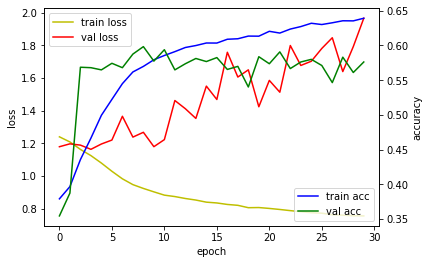

In [97]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower right')

plt.show()

## 모델 생성

In [ ]:
tf.keras.backend.clear_session()

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function
since target sequences are padded, deal this.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_sequences))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
  
  mask = tf.cast(tf.not_equal(y_true,0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate
use Adam optimizer with custom learning rate
$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Compile Model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, max_sequences))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## Train

In [ ]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
115/115 [==============================] - 7s 57ms/step - loss: 1.9745 - accuracy: 0.0212
Epoch 2/50
115/115 [==============================] - 7s 59ms/step - loss: 1.7337 - accuracy: 0.0333
Epoch 3/50
115/115 [==============================] - 7s 57ms/step - loss: 1.4780 - accuracy: 0.0421
Epoch 4/50
115/115 [==============================] - 7s 57ms/step - loss: 1.3197 - accuracy: 0.0458
Epoch 5/50
115/115 [==============================] - 7s 57ms/step - loss: 1.2290 - accuracy: 0.0561
Epoch 6/50
115/115 [==============================] - 6s 57ms/step - loss: 1.1427 - accuracy: 0.0669
Epoch 7/50
115/115 [==============================] - 6s 56ms/step - loss: 1.0619 - accuracy: 0.0749
Epoch 8/50
115/115 [==============================] - 7s 57ms/step - loss: 0.9901 - accuracy: 0.0812
Epoch 9/50
115/115 [==============================] - 7s 57ms/step - loss: 0.9265 - accuracy: 0.0865
Epoch 10/50
115/115 [==============================] - 7s 57ms/step - loss: 0.8684 - accura

## Category Classification

In [69]:
main = wear_data['MAIN']
category = wear_data['CATEGORY']
all_stc = wear_data['SENTENCE']

category_info = pd.DataFrame({"stc":all_stc, "cate":main})
rough_info = pd.DataFrame({"stc":all_stc, "cate":category})

In [19]:
category_info.dropna(inplace = True)
category_info.reset_index(drop=True, inplace = True)

rough_info.dropna(inplace = True)
rough_info.reset_index(drop=True, inplace = True)

print(category_info.shape, rough_info.shape)

(15725, 2) (15826, 2)


In [21]:
def make_tokenize(info):
    tagger = Okt()

    for i in range(info.shape[0]):
        info['stc'][i] = tagger.morphs(info['stc'][i])

make_tokenize(category_info)
make_tokenize(rough_info)

In [22]:
category_list = pd.factorize(category_info['cate'])[1]
category_info['cate'] = pd.factorize(category_info['cate'])[0]

rough_category_list = pd.factorize(rough_info['cate'])[1]
rough_info['cate'] = pd.factorize(rough_info['cate'])[0]

In [25]:
from tensorflow.keras.utils import to_categorical
category_ans = to_categorical(category_info['cate']) # 카테고리 관련 원핫벡터 카테고리
rough_ans = to_categorical(rough_info['cate']) # 4개 카테고리 관련 원핫벡터 카테고리

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

ctokenizer = Tokenizer(5000) 
ctokenizer.fit_on_texts(category_info['stc'])
ctoken_stc = ctokenizer.texts_to_sequences(category_info['stc'])
category_stc = ctoken_stc

rtokenizer = Tokenizer(5000) 
rtokenizer.fit_on_texts(rough_info['stc'])
rtoken_stc = rtokenizer.texts_to_sequences(rough_info['stc'])
rough_stc = rtoken_stc

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 15
category_stc = pad_sequences(category_stc, maxlen=max_len) # 카테고리 관련 패딩까지 마친 문장 모음
rough_stc = pad_sequences(rough_stc, maxlen=max_len) # 4개 카테고리 관련 패딩까지 마친 문장 모음

In [ ]:
from sklearn.model_selection import train_test_split

cX_train, cX_test, cy_train, cy_test = train_test_split(
    category_stc, category_ans, test_size = 0.2, shuffle = True, random_state = 11)

rX_train, rX_test, ry_train, ry_test = train_test_split(
    rough_stc, rough_ans, test_size = 0.2, shuffle = True, random_state = 11)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

cmodel = Sequential()
cmodel.add(Embedding(5000, 128))
cmodel.add(LSTM(128))
cmodel.add(Dense(405, activation='softmax'))

rmodel = Sequential()
rmodel.add(Embedding(5000, 100))
rmodel.add(LSTM(128))
rmodel.add(Dense(4, activation='softmax'))

In [ ]:
cmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
cmodel.fit(cX_train, cy_train, validation_data=(cX_test, cy_test), batch_size=32, epochs=30) # 128 64 32 실험

In [ ]:
rmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
rmodel.fit(rX_train, ry_train, validation_data=(rX_test, ry_test), batch_size=10, epochs=10) # 128 64 32 실험

In [ ]:
def find_category(stc,tokenizer,model,category_list):
    tagger = Okt()
    stc = tagger.morphs(stc)
    encode_stc = tokenizer.texts_to_sequences([stc])
    pad_stc = pad_sequences(encode_stc, maxlen=15)
    score = model.predict(pad_stc)
    return (category_list[score.argmax()], score[0, score.argmax()])

## Predict

In [ ]:
# 인덱스를 문장으로 변환
def convert_index_to_text(indexs, vocabulary): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == END_INDEX:
            # 종료 인덱스면 중지
            break;
        if vocabulary.get(index) is not None:
            # 사전에 있는 인덱스면 해당 단어를 추가
            sentence += vocabulary[index]
        else:
            # 사전에 없는 인덱스면 OOV 단어를 추가
            sentence.extend([vocabulary[OOV_INDEX]])
            
        # 빈칸 추가
        sentence += ' '

    return sentence

In [ ]:
# 예측을 위한 입력 생성
def make_predict_input(sentence):

    sentences = []
    sentences.append(sentence)
    sentences = pos_tag(sentences)
    input_seq = convert_text_to_index(sentences, word_to_index, ENCODER_INPUT)
    
    return input_seq

In [ ]:
def evaluate(input_seq):

  input_seq = input_seq.squeeze()
  sentence = tf.expand_dims(input_seq, axis=0)
  output = tf.expand_dims([1], 0)

  for i in range(max_sequences):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, 2):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

##doc2vec

In [ ]:
import os
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
import pandas as pd
import jpype
from konlpy.tag import Kkma

In [ ]:
import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
kkma = Kkma()
filter_kkma = ['NNG', 'NNP','OL','VA','VV','VXV']

def tokenizer_kkma(doc):
    # 꼬꼬마 형태소 분석기가 자바 기반이어서 파이썬에서 자바함수들을 실행할 수 있는 명령어 (jpype) 를 써줘야한다.
    jpype.attachThreadToJVM()       
    token_doc = ["/".join(word) for word in kkma.pos(doc)]
    return token_doc

def tokenize_kkma_noun_verb(doc):
    jpype.attachThreadToJVM()
    token_doc = ["/".join(word) for word in kkma.pos(doc) if word[1] in filter_kkma]
    return token_doc

In [ ]:
token_faqs = [(tokenizer_kkma(row[1]), row[0]) for row in faqs]
tagged_faqs = [TaggedDocument(d,[c]) for d,c in token_faqs]

In [ ]:
# 모델 만들기
# cpu 몇 개 쓸 건지
import multiprocessing
# 내 컴에 있는 cpu 갯수 cores 에 저장
cores = multiprocessing.cpu_count()
# vector_size : 임베딩할 벡터 차원
# negaive : negative sampling
d2v_faqs = doc2vec.Doc2Vec(
    vector_size = 100,
    alpha = 0.025,
    min_alpha = 0.025,
    hs = 1,
    negative = 0,
    dm = 0,
    dbow_words = 1,
    min_count = 1,
    workers = cores,
    seed = 0
)

# 단어 사전 만들기
d2v_faqs.build_vocab(tagged_faqs)
for epoch in range(4):
  # 모델 학습
  print(epoch)
  d2v_faqs.train(tagged_faqs,
                 total_examples = d2v_faqs.corpus_count,
                 epochs = d2v_faqs.epochs)
  d2v_faqs.alpha -=0.0025
  d2v_faqs.min_alpha = d2v_faqs.min_alpha

0
1
2
3


##합치기

In [ ]:
def give_cate(input_question): #카테고리추출하는 함수
  big_cate=find_category(input_question,ctokenizer,cmodel,category_list)
  samll_cate=find_category(input_question,rtokenizer,rmodel,rough_category_list)
  return big_cate,samll_cate #리턴값으로 큰카테고리(이름,유사도),작은 카테고리(이름,유사도)

def give_answer(input_question): #질문입력시 transfomer로 답변함
  return convert_index_to_text(evaluate(make_predict_input(input_question)).numpy()[1:],index_to_word)

def doc2_answer(input_question): #질문 입력시 doc2으로 답변함
  token_test = tokenizer_kkma(input_question)
  predict_vector = d2v_faqs.infer_vector(token_test)
  result = d2v_faqs.docvecs.most_similar([predict_vector],topn=1)
  return faqs[int(result[0][0])-1][2]

def score_calcul(left_cate,right_cate):#카테고리를 두개를 입력하면 유사도를 계산함
  result = 0
  if left_cate[0]==right_cate[0]:
    result += abs(left_cate[1]-right_cate[1])
  return result

In [ ]:
input_question = input()

q_big_cate,q_samll_cate=give_cate(input_question)

print(f"{q_big_cate},{q_samll_cate}")

dm=doc2_answer(input_question)
dm_big_cate,dm_small_cate=give_cate(dm)
cm=give_answer(input_question)
cm_big_cate,cm_small_cate=give_cate(cm)

doc2_score=0
tran_score=0

doc2_score += score_calcul(q_big_cate,dm_big_cate)
doc2_score += score_calcul(q_big_cate,dm_small_cate)
tran_score += score_calcul(q_big_cate,cm_big_cate)
tran_score += score_calcul(q_big_cate,dm_small_cate)

if doc2_score>=tran_score:
  print(f"***doc2: {dm}")
else:
  print(f"***tran: {cm}")

print("==================================")
print(f"doc2: {dm_big_cate},{dm_small_cate}")
print(dm)
if doc2_score!=0:
  print(doc2_score)
else:
  print("평가불가")
print("")
print(f"tran: {cm_big_cate},{cm_small_cate}")
print(cm)
if tran_score!=0:
  print(tran_score)
else:
  print("평가불가")

카운터에 있는 점원이 입고 있는 옷 맘에 드는데 어떤 제품인가요?
('유사제품추천문의', 0.6587085),('신발', 0.9972078)
***doc2: 네 피팅룸은 이쪽입니다
doc2: ('제품요청', 0.50416297),('의류', 0.999944)
네 피팅룸은 이쪽입니다
평가불가

tran: ('제품별추천문의', 0.67691714),('의류', 0.88469416)
고객 님 이 제품 은 어떠 신지 요 ? 
평가불가
